<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_CW_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Small dataset
!gdown --fuzzy https://drive.google.com/file/d/1y8OFnIFYC_b_WIexKSog732_L78Pegxa/view?usp=drive_link
!unzip -q brain_small.zip


Downloading...
From (original): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa
From (redirected): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa&confirm=t&uuid=e85b1dfe-732f-44b3-8a56-31fb9f946f72
To: /content/brain_small.zip
100% 119M/119M [00:00<00:00, 135MB/s] 


In [ ]:
# Full dataset
!gdown --fuzzy https://drive.google.com/file/d/1eSU-or72yvc3btOhfLO-edux5VBe_TrX/view?usp=sharing
!unzip -q brain.zip

Downloading...
From (original): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX
From (redirected): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX&confirm=t&uuid=258ab78c-f057-4849-b9f9-c82b21b4e2b8
To: /content/brain.zip
100% 4.97G/4.97G [01:08<00:00, 73.0MB/s]


In [2]:
from sklearn.model_selection import train_test_split
import shutil
import os

# data_path = "/content/brain"
# output_root = "/content/split"  # 輸出目錄
data_path = "/content/small"
output_root = "/content/split"  # 輸出目錄

# 創建輸出資料夾
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)
os.makedirs(os.path.join(output_root, "validation"), exist_ok=True)
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)

# 獲取所有樣本資料夾名稱
samples = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]

# 按照 70:15:15 的比例分割
train_samples, test_samples = train_test_split(samples, test_size=0.3, random_state=42)
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

print(f"Total samples: {len(samples)}")
print(f"Train samples: {len(train_samples)}, Validation samples: {len(validation_samples)}, Test samples: {len(test_samples)}")

# 定義拷貝函數
def move_samples(samples, output_dir):
    for sample in samples:
        src_path = os.path.join(data_path, sample)  # 原始路徑
        dst_path = os.path.join(output_dir, sample)  # 目標路徑
        if os.path.exists(dst_path):
            print(f"Sample {sample} already exists in {output_dir}, skipping.")
            continue
        shutil.copytree(src_path, dst_path)  # 拷貝整個資料夾
        # print(f"Moved {sample} to {output_dir}")

# 將樣本移動到各自的資料夾
move_samples(train_samples, os.path.join(output_root, "train"))
move_samples(validation_samples, os.path.join(output_root, "validation"))
move_samples(test_samples, os.path.join(output_root, "test"))

print("Data split and moved successfully!")


Total samples: 5
Train samples: 3, Validation samples: 1, Test samples: 1
Data split and moved successfully!


EarlyStopping & Visualization

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0.00005, path="checkpoint.pt"):
        """
        Args:
            patience (int): 容忍驗證損失未改善的次數 (default: 5)
            verbose (bool): 是否打印相關資訊 (default: False)
            delta (float): 最小改善幅度，只有超過此值才算改善 (default: 0)
            path (str): 模型權重保存路徑 (default: "checkpoint.pt")
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")

    def __call__(self, val_loss, model):
        # 計算當前得分（驗證損失的負值，因為越小越好）
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """保存當前模型權重"""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def visualize_results(input_image, target_image, predicted_image, epoch, idx):
    """
    視覺化輸入影像、目標影像與預測影像
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 輸入影像
    axes[0].imshow(input_image[0, 0, :, :, input_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Input (MR)")
    axes[0].axis("off")

    # 目標影像3
    axes[1].imshow(target_image[0, 0, :, :, target_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Target (CT)")
    axes[1].axis("off")

    # 預測影像
    axes[2].imshow(predicted_image[0, 0, :, :, predicted_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Prediction (Generated CT)")
    axes[2].axis("off")

    plt.suptitle(f"Epoch {epoch}, Batch {idx}")
    plt.show()

GAN model

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
from scipy.ndimage import zoom


# Data preprocessing and dataset class
class MRCTDataset(Dataset):
    def __init__(self, data_dir, target_size=(128, 128, 128)):
        self.data_dir = data_dir
        self.target_size = target_size
        self.samples = [
            os.path.join(root)
            for root, _, files in os.walk(data_dir)
            if "mr.nii.gz" in files and "ct.nii.gz" in files and "mask.nii.gz" in files
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.samples[idx]
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        mr = self._normalize(mr)
        ct = self._normalize(ct)

        mr = self._resize_or_pad(mr, self.target_size)
        ct = self._resize_or_pad(ct, self.target_size)

        mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)
        ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)

        return mr, ct

    def _normalize(self, image):
        return (image - np.mean(image)) / (np.std(image) + 1e-5)

    def _resize_or_pad(self, image, target_size):
        zoom_factors = [t / s for t, s in zip(target_size, image.shape)]
        return zoom(image, zoom_factors, order=1)

# Generator and Discriminator Networks
class Generator(nn.Module):   # to transform MR to CT using 3D CNN
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()   # 使範圍在[-1, 1]
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):  # to tell whether the input image is the ground truth from the dataset or generated by the generator
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()       # 使範圍在[0, 1] 希望判斷真實影像時越接近1，希望判斷生成影像時越接近0
        )

    def forward(self, x):
        return self.model(x)

Epoch [1/10], Step [1/1], D Loss: 0.7245, G Loss: 0.9167


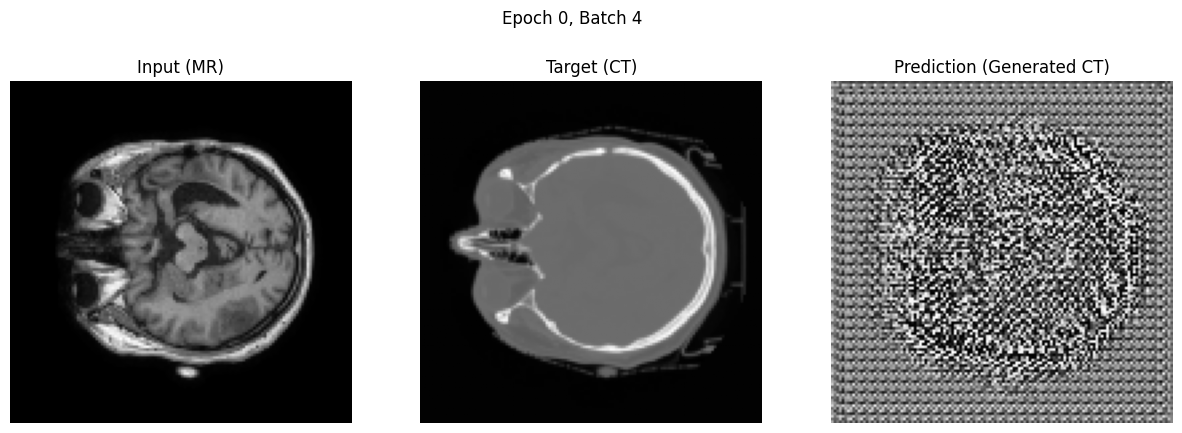

Shape of fake: torch.Size([3, 1, 16, 16, 16]), Shape of real: torch.Size([3, 1, 16, 16, 16])
Epoch 1/10, Avg Validation Loss: 0.9536, SSIM: 0.0130
Validation loss decreased (inf --> 1.940525). Saving model...
Epoch [2/10], Step [1/1], D Loss: 0.6289, G Loss: 1.0566


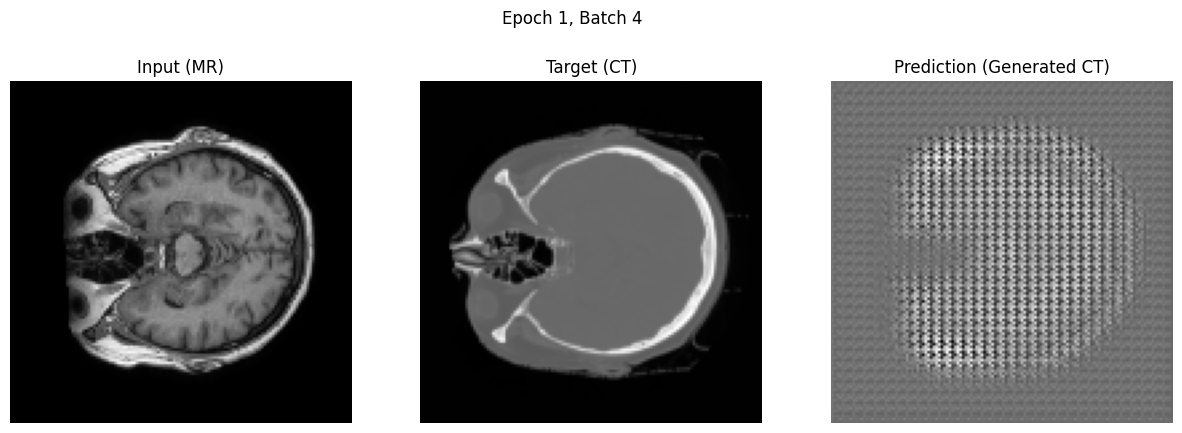

Shape of fake: torch.Size([3, 1, 16, 16, 16]), Shape of real: torch.Size([3, 1, 16, 16, 16])
Epoch 2/10, Avg Validation Loss: 0.9619, SSIM: -0.0086
EarlyStopping counter: 1 out of 5
Epoch [3/10], Step [1/1], D Loss: 0.4829, G Loss: 1.0002


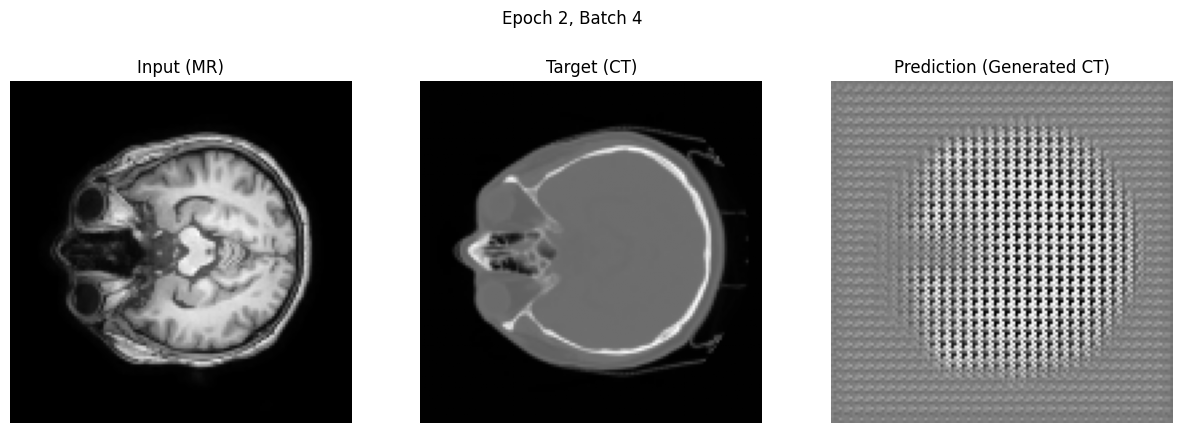

Shape of fake: torch.Size([3, 1, 16, 16, 16]), Shape of real: torch.Size([3, 1, 16, 16, 16])
Epoch 3/10, Avg Validation Loss: 0.9467, SSIM: -0.0097
EarlyStopping counter: 2 out of 5
Epoch [4/10], Step [1/1], D Loss: 0.4213, G Loss: 0.9460


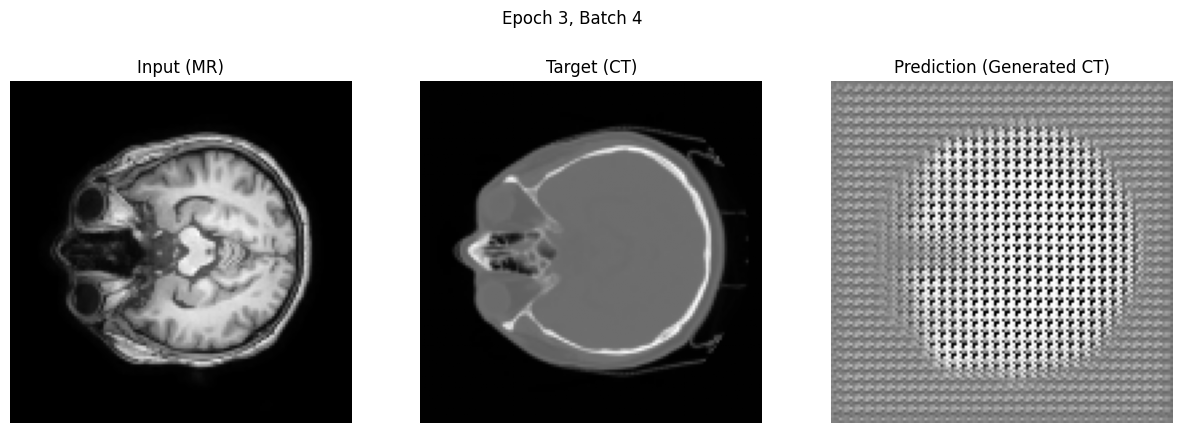

Shape of fake: torch.Size([3, 1, 16, 16, 16]), Shape of real: torch.Size([3, 1, 16, 16, 16])
Epoch 4/10, Avg Validation Loss: 0.9252, SSIM: -0.0012
Validation loss decreased (1.940525 --> 1.926436). Saving model...


KeyboardInterrupt: 

In [9]:
# Training Loop
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def calculate_ssim(fake, real):
    # 確保數據形狀為 (N, C, D, H, W)
    fake_np = fake.squeeze(1).cpu().numpy()  # 去掉單通道 (C=1)
    real_np = real.squeeze(1).cpu().numpy()

    ssim_values = []
    for i in range(fake_np.shape[0]):  # 遍歷批次
        for d in range(fake_np.shape[1]):  # 遍歷深度維度
            ssim_value = ssim(
                fake_np[i, d], real_np[i, d], data_range=real_np[i, d].max() - real_np[i, d].min()
            )
            ssim_values.append(ssim_value)

    return sum(ssim_values) / len(ssim_values)  # 返回平均 SSIM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_gan(data_loader, val_loader, generator, discriminator, g_optimizer, d_optimizer, criterion, epochs=10, device='cuda'):
    generator.to(device)
    discriminator.to(device)

    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.00005, path="checkpoint.pt")

    for epoch in range(epochs):
        for i, (mr, ct) in enumerate(data_loader):
            mr, ct = mr.to(device), ct.to(device)

            # Train Discriminator
            real_output = discriminator(ct)
            fake_ct = generator(mr)
            fake_ct = torch.sigmoid(fake_ct)  # 保證範圍在 [0, 1]
            fake_output = discriminator(fake_ct.detach())

            d_loss_real = criterion(real_output, torch.ones_like(real_output))
            d_loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = (d_loss_real + d_loss_fake) / 2

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            fake_output = discriminator(fake_ct)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # 可視化結果：每 5 個 epoch 執行一次
        # visualize_results(mr, ct, fake_ct, epoch, idx=1)
        random_idx = torch.randint(0, len(mr), (1,)).item()
        visualize_results(mr[random_idx:random_idx+1], ct[random_idx:random_idx+1], fake_ct[random_idx:random_idx+1], epoch, idx=4)
        print(f"Shape of fake: {fake_output.shape}, Shape of real: {real_output.shape}")


        # validation
        generator.eval()
        val_loss = 0.0
        ssim_score = 0.0  # Example for SSIM metric
        with torch.no_grad():
            for mr, ct in val_loader:
                mr, ct = mr.to(device), ct.to(device)
                fake_ct = generator(mr)
                # fake_ct = torch.sigmoid(fake_ct)

                # 使用 MSE Loss 或 SSIM 作為附加度量
                loss = F.mse_loss(fake_ct, ct)
                val_loss += loss.item()

                # 計算 SSIM
                ssim_score += calculate_ssim(fake_ct, ct)  # 需要自定義計算 SSIM 的函數

        avg_val_loss = val_loss / len(val_loader)
        avg_ssim = ssim_score / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avg Validation Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}")


        # 調用 EarlyStopping
        early_stopping(avg_val_loss + (1 - avg_ssim), generator)

        # 如果觸發 EarlyStopping，結束訓練
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break


# Main Script
if __name__ == "__main__":
    train_data = "/content/split/train"
    val_data = "/content/split/validation"
    test_data = "/content/split/test"
    train_set = MRCTDataset(train_data)
    val_set = MRCTDataset(val_data)
    val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
    data_loader = DataLoader(train_set, batch_size=4, shuffle=True)

    generator = Generator()
    discriminator = Discriminator()

    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0005)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005)

    train_gan(data_loader, val_loader, generator, discriminator, g_optimizer, d_optimizer, criterion)
